In [9]:
#CELL TO CONNECT GOOGLE DRIVE TO COLAB

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Install ClearML, Ultralytics and import Yolo

!pip install ultralytics
!pip install clearml
import os
from ultralytics import YOLO


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [2]:
#FINETUNING AND CONFIGURATION TO MAKE EXPERIMENT  EASY TO MANAGE: https://www.kaggle.com/code/hinepo/yolov8-finetuning-for-ppe-detection

class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88
    # training
    EPOCHS = 3 if DEBUG else 300 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8l' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'

    #train directory and ClearML tracking, manually edit  epochs if resume training.
    EXP_NAME = f'Experiment-11_PPE_Detector_{BASE_MODEL}_{EPOCHS}_epochs'

    CONTINUE_LAST_TASK = False  #Or task ID (if you want continue a previous experiment)

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0


    # paths
    ROOT_DIR = '/content/gdrive/My Drive/PPE Detection/' #WRITE YOU ROOT DIRECTORY HERE




In [4]:
#Configure and start ClearML for experiment tracking

from clearml import Task, Logger
Task.set_credentials(
    api_host = "https://api.clear.ml",
    web_host = "https://app.clear.ml",
    files_host = "https://files.clear.ml",
    key = 'key', # Your ClearML key
    secret =  'secret' #Your ClearML secret key
)
task = Task.init(project_name = 'PPE Detection', task_name = CFG.EXP_NAME, continue_last_task = CFG.CONTINUE_LAST_TASK)

NameError: name 'CFG' is not defined

100%|██████████| 83.7M/83.7M [00:00<00:00, 229MB/s]


2024-02-03 13:38:39,938 - clearml.model - INFO - Selected model id: 2629e686540a443f985f1a914f0199dd
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/gdrive/My Drive/PPE Detection/data.yaml, epochs=300, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=Experiment-11_PPE_Detector_yolov8l_300_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              


  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 6.23M/6.23M [00:00<00:00, 85.0MB/s]


AMP: checks passed ✅


train: Scanning /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/train/labels... 1563 images, 5 backgrounds, 0 corrupt: 100%|██████████| 1563/1563 [05:46<00:00,  4.52it/s]

train: WARNING ⚠️ /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/train/images/construction-844-_jpg.rf.1985f626f3dbf5577df7470499f60922.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/train/images/n190039_jpg.rf.2828f00d964c43db9d2b7c7f95152415.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/train/images/youtube-571_jpg.rf.05b2a9ffc13b71ed88701ac00e713eba.jpg: 1 duplicate labels removed


train: New cache created: /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:24<00:00,  4.63it/s]

val: New cache created: /content/gdrive/My Drive/PPE Detection/data/Construction Site Safety.v29i.yolov8/valid/labels.cache


Plotting labels to runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      10.9G      1.289      1.949        1.5        304        640: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        114        697       0.57      0.389        0.4      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      11.4G      1.298      1.648      1.496        425        640: 100%|██████████| 98/98 [01:21<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        114        697      0.545       0.34      0.352      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.2G       1.31      1.672      1.508        341        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        114        697      0.422      0.405      0.368      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      10.9G      1.318       1.65      1.497        188        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        114        697      0.492      0.418        0.4      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.2G      1.251      1.531      1.459        186        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.621       0.46      0.481      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.2G      1.239      1.506      1.448        322        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        114        697      0.663      0.443      0.504      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G      1.207      1.412      1.425        217        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.683        0.5      0.547      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      10.9G      1.184      1.389      1.406        256        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.704      0.516       0.57      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.2G      1.163      1.339      1.391        157        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        114        697      0.711      0.561      0.591       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.2G      1.139      1.263      1.376        203        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        114        697      0.722      0.565      0.625      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300        11G      1.116      1.199      1.347        410        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        114        697      0.782       0.57      0.642      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      11.2G      1.107      1.184      1.348        324        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        114        697       0.74      0.613      0.652      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.2G      1.085      1.161      1.336        348        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.754      0.604       0.65      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      10.9G      1.065      1.109       1.32        223        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        114        697      0.774      0.602      0.645      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.2G      1.067      1.105      1.317        284        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.775      0.585      0.657       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.3G      1.058      1.076      1.304        371        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.787      0.623      0.689      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.2G      1.055      1.057      1.309        139        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        114        697      0.765      0.619      0.656      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.3G      1.026      1.014      1.285        156        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        114        697      0.785      0.643        0.7      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.2G      1.011     0.9946       1.28        265        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        114        697      0.807      0.597      0.668      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.3G      1.003     0.9745      1.275        281        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697       0.76      0.678      0.703      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.2G     0.9798     0.9317      1.252        223        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        114        697      0.835      0.627        0.7      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.3G     0.9721     0.9191      1.247        303        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697       0.79      0.638      0.702      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.3G     0.9621     0.8974      1.239        243        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        697       0.83      0.622      0.706      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.3G     0.9487     0.8795      1.233        317        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697      0.834       0.65      0.726      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.2G     0.9459     0.8615      1.228        300        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.826      0.684      0.724      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.2G     0.9496     0.8836      1.233        157        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.865      0.673       0.72      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.1G     0.9336     0.8522      1.218        286        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        114        697      0.863      0.656      0.731      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      11.2G     0.9266     0.8397      1.216        188        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.826      0.661      0.731      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.3G     0.9203     0.8245      1.207        314        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.811       0.63      0.694      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.2G      0.903     0.8105      1.196        278        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        114        697      0.806      0.681       0.73      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.2G     0.9052     0.8061      1.201        177        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        114        697      0.823      0.673      0.745      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.3G     0.8927     0.7765      1.185        197        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        114        697      0.864      0.668      0.731      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.2G     0.8607     0.7592      1.179        194        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        114        697       0.87      0.672      0.746       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      11.2G     0.8577      0.748      1.172        174        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.854       0.67      0.735      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        11G     0.8668     0.7577      1.173        197        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        114        697      0.888      0.687       0.76      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      11.1G     0.8629     0.7505       1.17        200        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.865      0.655      0.742      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      10.9G     0.8514     0.7267      1.158        246        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        114        697      0.873      0.676       0.75      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      11.1G     0.8532     0.7392      1.168        274        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.908      0.658      0.743      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.2G     0.8498     0.7346      1.164        265        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        114        697      0.874      0.669      0.753      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      11.3G     0.8295     0.7193       1.15        322        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697        0.9      0.685      0.775      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      11.3G     0.8367     0.6953      1.147        249        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        114        697      0.859      0.675      0.764      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.3G      0.836      0.701       1.15        250        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        114        697      0.879      0.683      0.759      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      11.2G     0.8101     0.6662      1.137        199        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.879      0.692      0.764      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.3G     0.8214     0.6877      1.139        234        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        697      0.873      0.687      0.764      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      11.2G     0.7963     0.6604      1.128        122        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.912      0.691      0.775      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.2G     0.7979     0.6638      1.128        308        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697      0.903      0.685      0.761      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.1G     0.7833     0.6345      1.109        268        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.862      0.696      0.774      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.3G     0.7793     0.6451      1.114        320        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        114        697      0.874      0.708       0.78      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G     0.7819     0.6442      1.117        253        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        114        697      0.925      0.677      0.779      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      11.1G     0.7682     0.6214      1.105        231        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        114        697      0.865      0.702      0.777      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300        11G     0.7746     0.6336      1.112        227        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.897      0.702      0.771      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      11.3G     0.7763     0.6275      1.103        272        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.874      0.686      0.763      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G     0.7632     0.6025      1.096        215        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.892      0.731      0.798       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      11.3G     0.7491     0.6059      1.091        256        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        114        697        0.9      0.717      0.788      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G     0.7401     0.5967      1.098        187        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.885      0.726      0.784      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.3G     0.7566     0.6054      1.098        159        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.892      0.721       0.78      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.2G     0.7364     0.5852      1.086        239        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        114        697      0.869      0.719      0.785       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      11.3G       0.72     0.5747      1.085        304        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.904      0.715      0.787      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      10.9G       0.73     0.5765      1.079        214        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        114        697      0.894      0.729       0.79      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      11.3G     0.7299     0.5762      1.081        147        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.868      0.745      0.803       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      11.3G     0.7054     0.5607      1.073        280        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        114        697      0.874      0.721      0.778      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      11.2G     0.7276     0.5855      1.081        275        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.896      0.736      0.797      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      10.9G     0.7156     0.5662      1.072        212        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        114        697      0.902      0.721      0.796        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.2G     0.7116     0.5635      1.069        207        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.883      0.723      0.801      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      11.2G     0.6923     0.5486      1.065        250        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697       0.89      0.741       0.81      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.3G     0.7065     0.5573      1.069        243        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        114        697      0.899      0.725      0.798       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      11.2G     0.7042     0.5534      1.067        262        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.925      0.714      0.798      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.3G       0.69     0.5397      1.058        309        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.912      0.716      0.784      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.3G      0.692     0.5549      1.069        243        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.914      0.731      0.801      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.3G     0.6946     0.5508      1.061        228        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        114        697      0.902      0.722      0.799      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.2G     0.6861     0.5368      1.055        210        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.915      0.722      0.802      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.2G     0.6829     0.5388       1.05        228        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        114        697      0.952      0.731       0.82      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.2G     0.6815     0.5397      1.055        316        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.914       0.75      0.812      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.3G     0.6781     0.5207      1.051        289        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        114        697      0.891      0.758      0.813      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.2G     0.6813     0.5229      1.047        313        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697       0.91      0.722      0.803      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.3G     0.6684     0.5196      1.045        282        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.901      0.743      0.801      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G     0.6727     0.5223       1.05        228        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.911      0.751      0.823      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      11.2G     0.6776     0.5217      1.044        234        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697        0.9      0.767      0.821      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.2G     0.6573     0.5094      1.034        301        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.884      0.765      0.811      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.2G     0.6519     0.5046      1.039        242        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697      0.898      0.757      0.821       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.2G     0.6471     0.4928      1.029        272        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.881      0.762      0.816      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      11.3G     0.6707     0.5077      1.037        218        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697      0.893      0.743      0.803      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.3G     0.6512      0.496      1.031        222        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.918      0.766      0.822      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.3G     0.6325     0.4808      1.019        234        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.905      0.759      0.818      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.2G      0.646     0.4908      1.025        294        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.927       0.74      0.829      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.3G     0.6522     0.5068      1.033        233        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        114        697       0.92      0.742      0.815      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      10.9G     0.6329      0.486      1.024        227        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.933      0.733      0.815      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      11.3G     0.6503     0.4929      1.034        185        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.919       0.74       0.81      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      11.2G     0.6332     0.4843      1.022        179        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        114        697      0.895      0.755      0.813      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.2G     0.6391     0.4933      1.026        294        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.935      0.736      0.818      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G     0.6198     0.4765      1.021        238        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.905      0.733      0.814      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      11.3G     0.6225     0.4726      1.022        208        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        114        697      0.927      0.728       0.81      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300        11G     0.6192     0.4707      1.015        176        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        114        697      0.936      0.727      0.821      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.2G     0.6115     0.4632      1.012        225        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        114        697      0.935      0.749      0.834      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      10.9G     0.6074     0.4651      1.011        243        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697        0.9      0.763      0.823      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      11.3G     0.6136     0.4654      1.013        357        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697       0.89      0.757      0.817      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.2G     0.6108     0.4624      1.009        243        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697       0.88      0.756       0.82      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.3G     0.6014     0.4605      1.006        163        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        114        697      0.892      0.769      0.823      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.3G     0.6004     0.4478      1.005        226        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        114        697      0.927      0.744      0.823      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.3G     0.5977     0.4511      1.006        172        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.916      0.738      0.828      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.2G     0.6092     0.4594      1.001        193        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        114        697      0.887      0.777      0.831      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      11.2G     0.5965     0.4543     0.9998        433        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        114        697      0.943      0.733      0.823      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      10.8G     0.6048     0.4613      1.003        192        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        114        697      0.926      0.763      0.834      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.1G     0.5949     0.4462      1.003        192        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.924      0.763      0.827      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.2G     0.5846     0.4374     0.9949        229        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.943       0.75       0.84      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.2G     0.5848     0.4376     0.9905        234        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.929      0.763      0.832      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G     0.5975      0.447     0.9992        264        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        114        697       0.93      0.757      0.831      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.3G     0.5928     0.4434     0.9914        224        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697       0.94      0.766      0.834      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      10.9G     0.5775     0.4319     0.9908        300        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        114        697      0.902      0.765      0.826      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.1G     0.5888     0.4376     0.9946        226        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.907      0.769      0.836      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.2G     0.5675      0.426      0.984        182        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        114        697      0.897      0.753      0.818      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      11.2G      0.568     0.4248     0.9807        151        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        114        697      0.932       0.76      0.831      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.2G     0.5667     0.4237     0.9855        238        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.902      0.781      0.837       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.3G     0.5659     0.4168     0.9852        350        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697       0.91      0.778      0.832       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.2G     0.5724     0.4287       0.99        203        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.949      0.758      0.841      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      10.9G      0.566     0.4254     0.9833        261        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        114        697      0.932      0.778      0.838       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.2G     0.5661     0.4189      0.978        259        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.954       0.76      0.837      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      11.3G     0.5656     0.4198     0.9823        249        640: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        114        697      0.937      0.754      0.839      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.2G     0.5601     0.4171      0.976        214        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.928      0.765      0.837      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      11.2G     0.5581     0.4131     0.9737        260        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        114        697      0.915      0.769      0.839      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.1G     0.5495     0.4119     0.9712        217        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        114        697      0.942      0.763      0.843      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.1G     0.5594     0.4112     0.9778        130        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        114        697      0.907      0.773      0.841      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.1G     0.5507     0.4095     0.9731        205        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.914      0.765      0.835      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      11.2G     0.5568      0.411     0.9786        236        640: 100%|██████████| 98/98 [01:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        114        697      0.903      0.777      0.831      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.2G     0.5581     0.4101     0.9764        253        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        697      0.926      0.747       0.83       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      11.3G     0.5553     0.4097     0.9766        299        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        114        697      0.915      0.773      0.843      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      10.8G     0.5446     0.4017     0.9694        315        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        697      0.898      0.766      0.833       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.3G     0.5429        0.4     0.9715        187        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        114        697      0.924      0.761      0.829      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.2G     0.5425     0.4046     0.9707        272        640: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.928      0.761      0.832      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.1G     0.5417     0.4015     0.9723        140        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        697      0.927      0.772      0.835      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.2G     0.5386     0.4024     0.9683        232        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        114        697      0.925      0.771      0.832      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      11.3G     0.5462     0.4015     0.9755        183        640: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697       0.94      0.767      0.838      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.2G     0.5364     0.3945     0.9609        206        640: 100%|██████████| 98/98 [01:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        114        697      0.932      0.763      0.829      0.552
Stopping training early as no improvement observed in last 20 epochs. Best results observed at epoch 113, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



133 epochs completed in 3.341 hours.
Optimizer stripped from runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs/weights/best.pt, 87.7MB

Validating runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43614318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


                   all        114        697        0.9       0.78      0.836      0.569
Speed: 0.2ms preprocess, 18.4ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/detect/Experiment-11_PPE_Detector_yolov8l_300_epochs
2024-02-03 17:06:13,228 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/PPE%20Detection/Experiment-11_PPE_Detector_yolov8l_300_epochs.ec6cf7b0f4974171b88e44f4a3e6707d/models/best.pt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 MB 9.9 MB/s eta 0:00:00


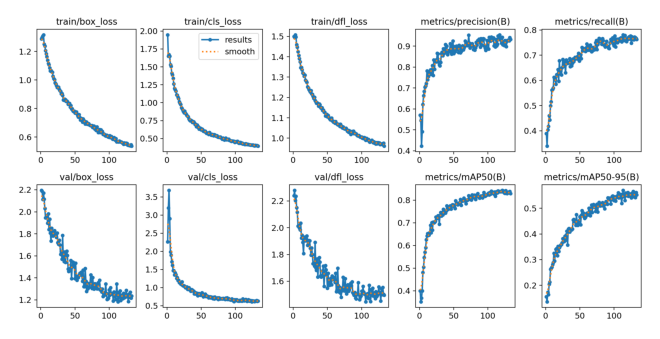

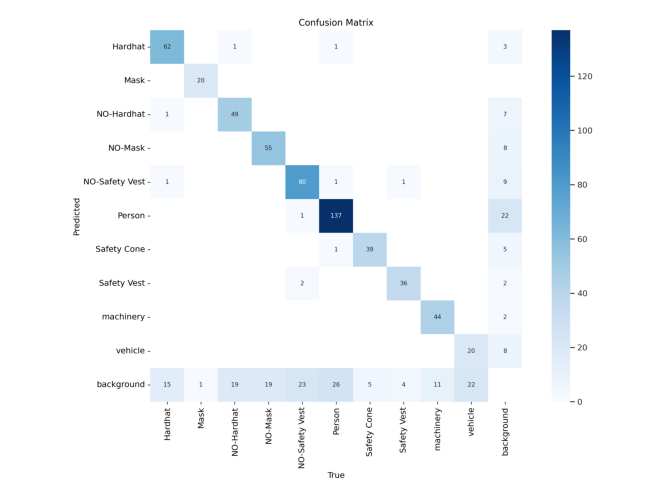

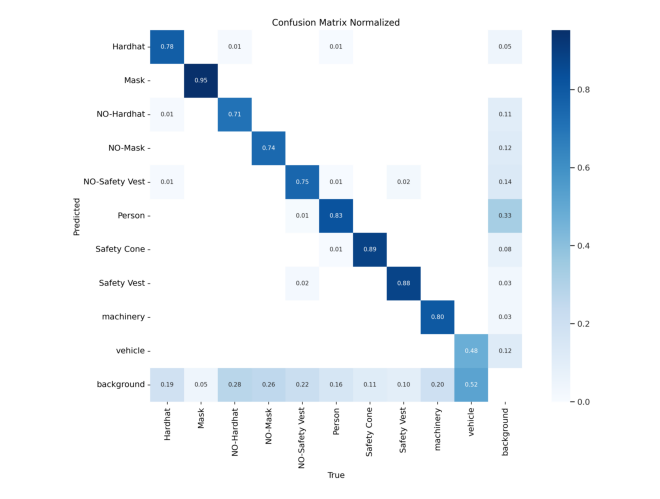

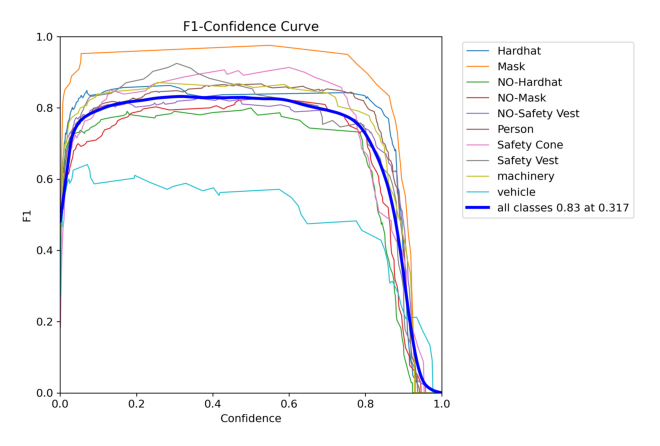

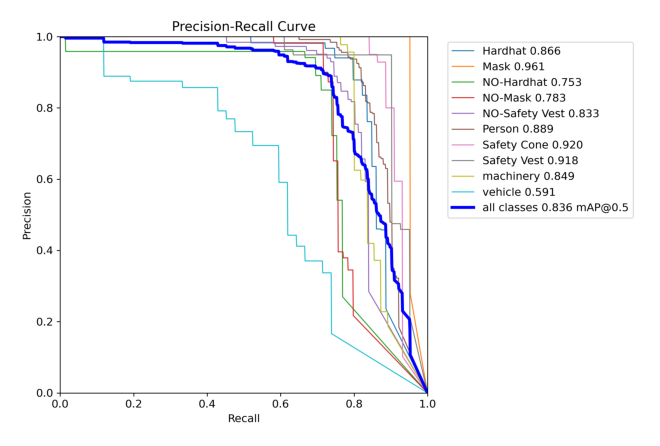

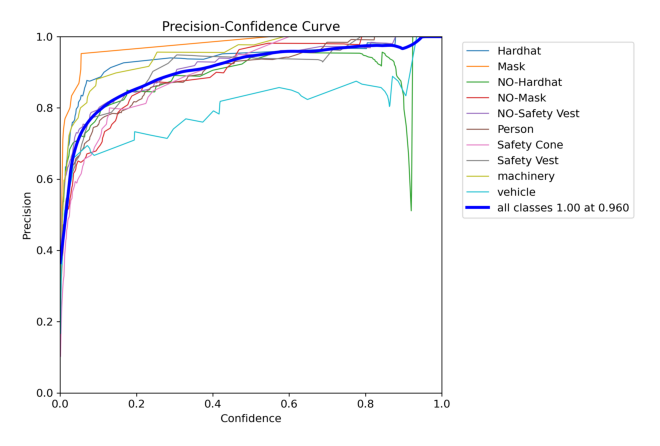

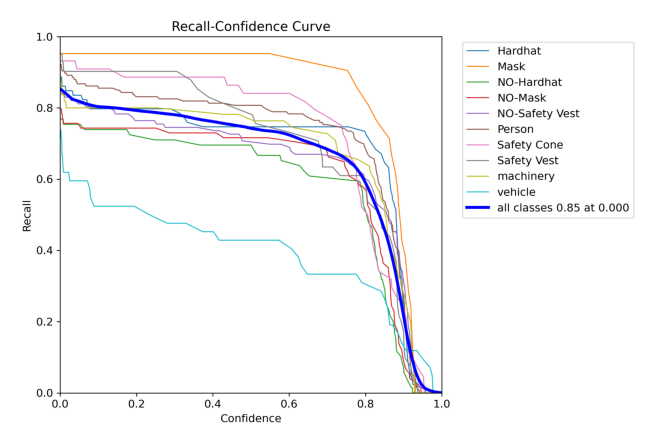

In [4]:
# Train model

#Load model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

#Use model
model.train(
    data=os.path.join(CFG.ROOT_DIR, "data.yaml"),
    task = 'detect',
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.EXP_NAME}',
    seed = CFG.SEED,
    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
    )

#SAVE OUTPUT TO GOOGLE DRIVE
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install aspose-words
!scp -r /content/runs/ '/content/gdrive/My Drive/PPE Detection/' #adjust it manually if don't work


In [5]:
#Get weights to make inference

model = YOLO("/content/gdrive/MyDrive/PPE Detection/runs/detect/PPE_Detector_yolov8l_finetuning-133_epochs/weights/best.pt")

In [ ]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

In [ ]:
#Make inference on a video

!yolo detect predict model = "/content/gdrive/MyDrive/PPE Detection/runs/detect/PPE_Detector_yolov8l_finetuning-133_epochs/weights/best.pt"  source = "/content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4"

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Model summary (fused): 268 layers, 43614318 parameters, 0 gradients, 164.9 GFLOPs

video 1/1 (1/758) /content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4: 384x640 3 NO-Safety Vests, 4 Persons, 3 Safety Vests, 1462.9ms
video 1/1 (2/758) /content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4: 384x640 2 NO-Safety Vests, 4 Persons, 3 Safety Vests, 1412.9ms
video 1/1 (3/758) /content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4: 384x640 1 NO-Mask, 2 NO-Safety Vests, 3 Persons, 3 Safety Vests, 1423.2ms
video 1/1 (4/758) /content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4: 384x640 2 NO-Safety Vests, 4 Persons, 3 Safety Vests, 1228.8ms
video 1/1 (5/758) /content/gdrive/MyDrive/PPE Detection/data/videos/workers-video-1.mp4: 384x640 2 NO-Safety Vests, 5 Persons, 3 Safety Vests, 1269.4ms
video 1/1 (6/758) /content/gdrive/MyDrive/PPE Detection/data/videos/

In [7]:
#Save the video on runs/

!scp -r /content/runs '/content/gdrive/My Drive/PPE Detection/'

In [11]:
#Convert the video to mp4 format
!ffmpeg -i {"/content/gdrive/MyDrive/PPE Detection/runs/detect/predict/workers-video-2.avi"} -vcodec libx264 {"yolov8l-ppe-detection-video-1.mp4"}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab